# Import Libraries

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from category_encoders.target_encoder import TargetEncoder
from xgboost import XGBRegressor
from skopt import BayesSearchCV
from sklearn.metrics import accuracy_score,mean_absolute_error, mean_squared_error, r2_score
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1 - Explore and prep data

In [2]:
df = pd.read_csv("C:\\Users\\rmct2\\OneDrive - Sri Lanka Institute of Information Technology\\Desktop\\SLIIT\\Y3S1\\FDM\\car_prices.csv")

In [3]:
df.describe(include=['object'])

,make,model,trim,body,transmission,vin,state,color,interior,seller,saledate
count,548536,548438,548186,545642,493485,558833,558837,558088,558088,558837,558825
unique,96,973,1963,87,4,550297,64,46,17,14263,3766
top,Ford,Altima,Base,Sedan,automatic,automatic,fl,black,black,nissan-infiniti lt,Tue Feb 10 2015 01:30:00 GMT-0800 (PST)
freq,93554,19349,55817,199437,475915,22,82945,110970,244329,19693,5334


In [3]:
# Select categorical columns 
categorical_columns = ['make','model','trim','body','transmission','vin','state','color','interior','seller','saledate']  

In [4]:
df.describe()

,year,condition,odometer,mmr,sellingprice
count,558837.000000,547017.000000,558743.000000,558799.000000,558825.000000
mean,2010.038927,30.672365,68320.017767,13769.377495,13611.358810
std,3.966864,13.402832,53398.542821,9679.967174,9749.501628
min,1982.000000,1.000000,1.000000,25.000000,1.000000
25%,2007.000000,23.000000,28371.000000,7100.000000,6900.000000
50%,2012.000000,35.000000,52254.000000,12250.000000,12100.000000
75%,2013.000000,42.000000,99109.000000,18300.000000,18200.000000
max,2015.000000,49.000000,999999.000000,182000.000000,230000.000000


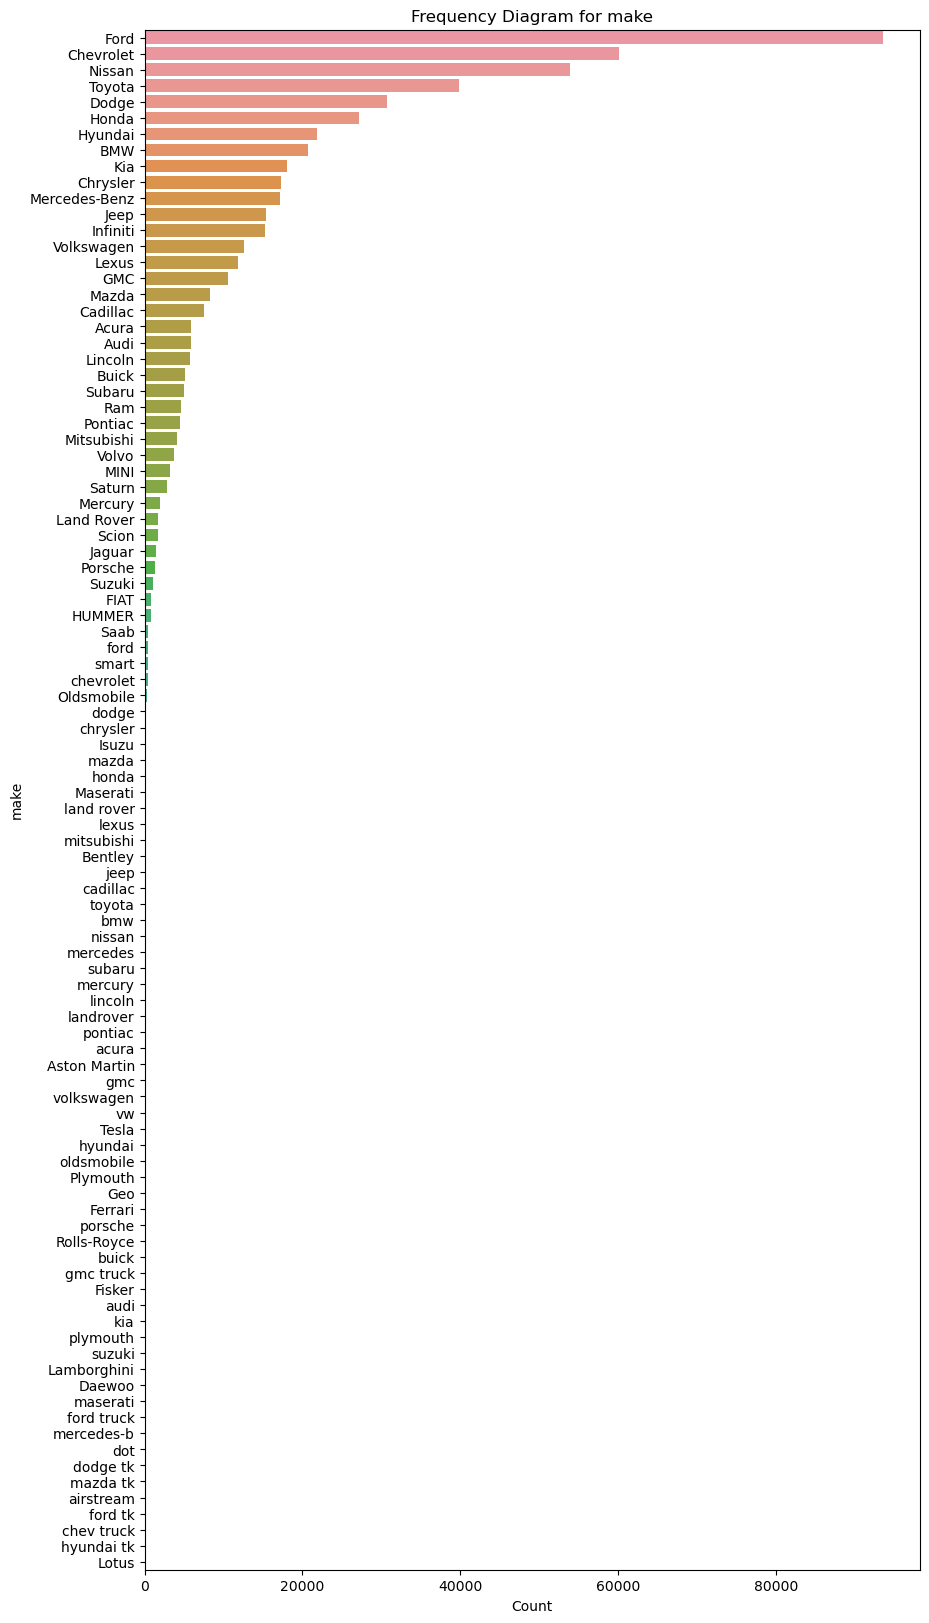

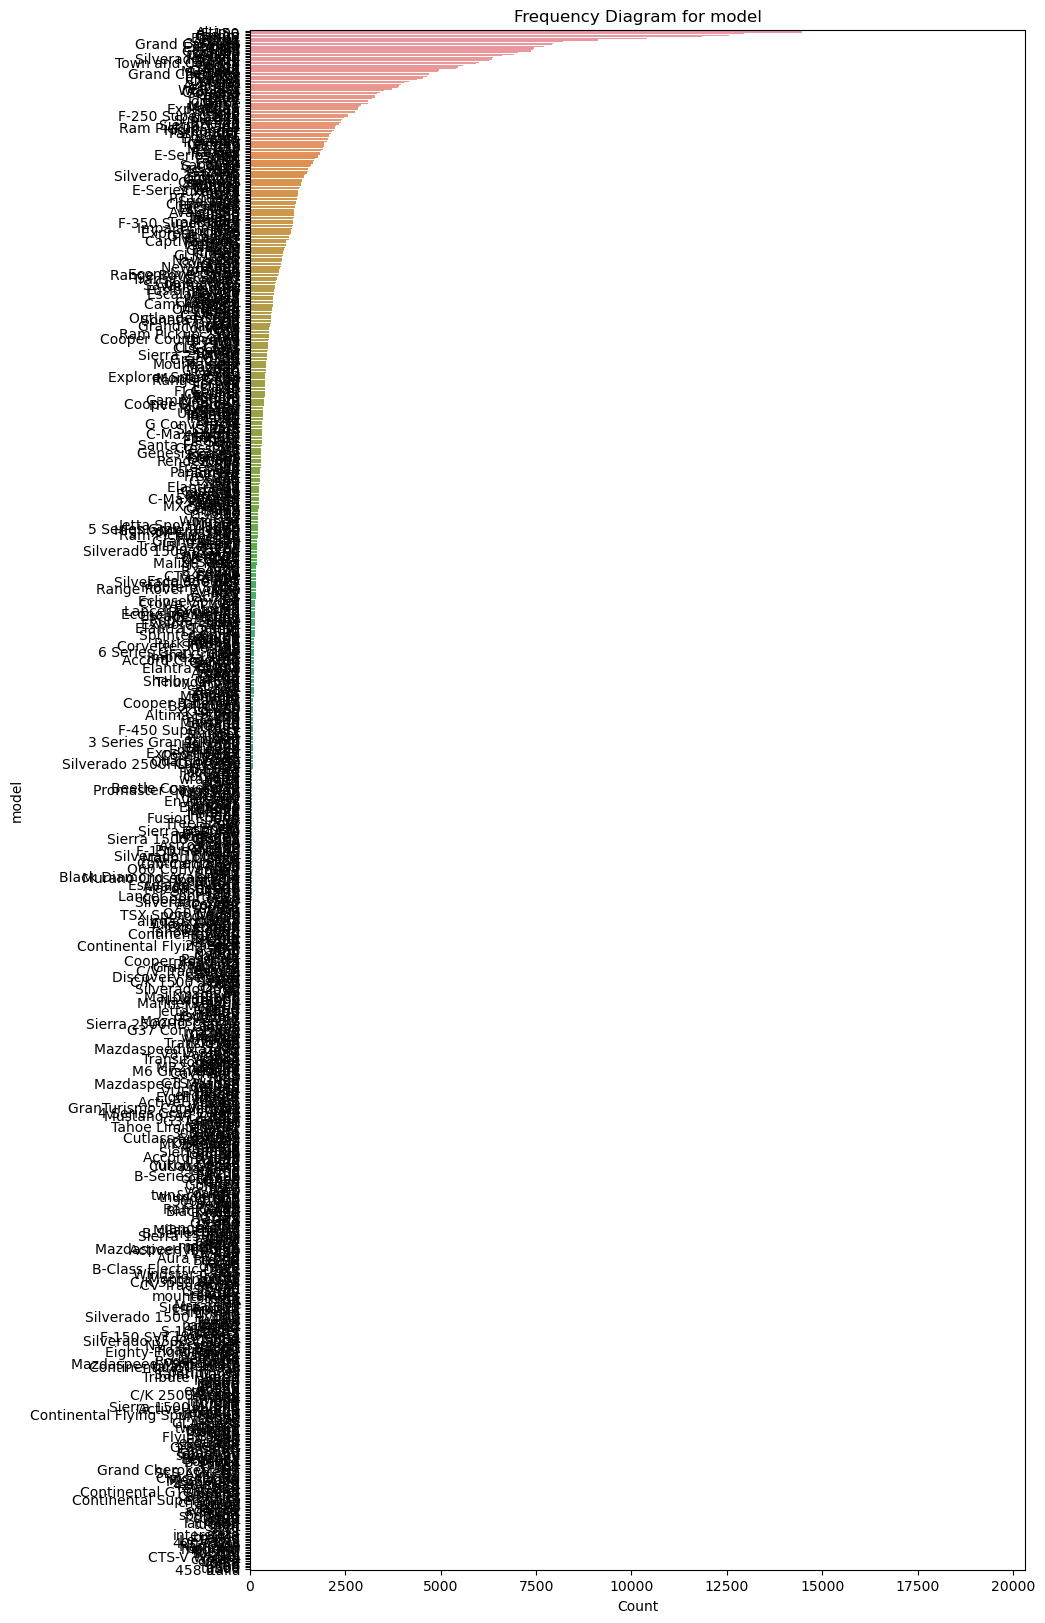

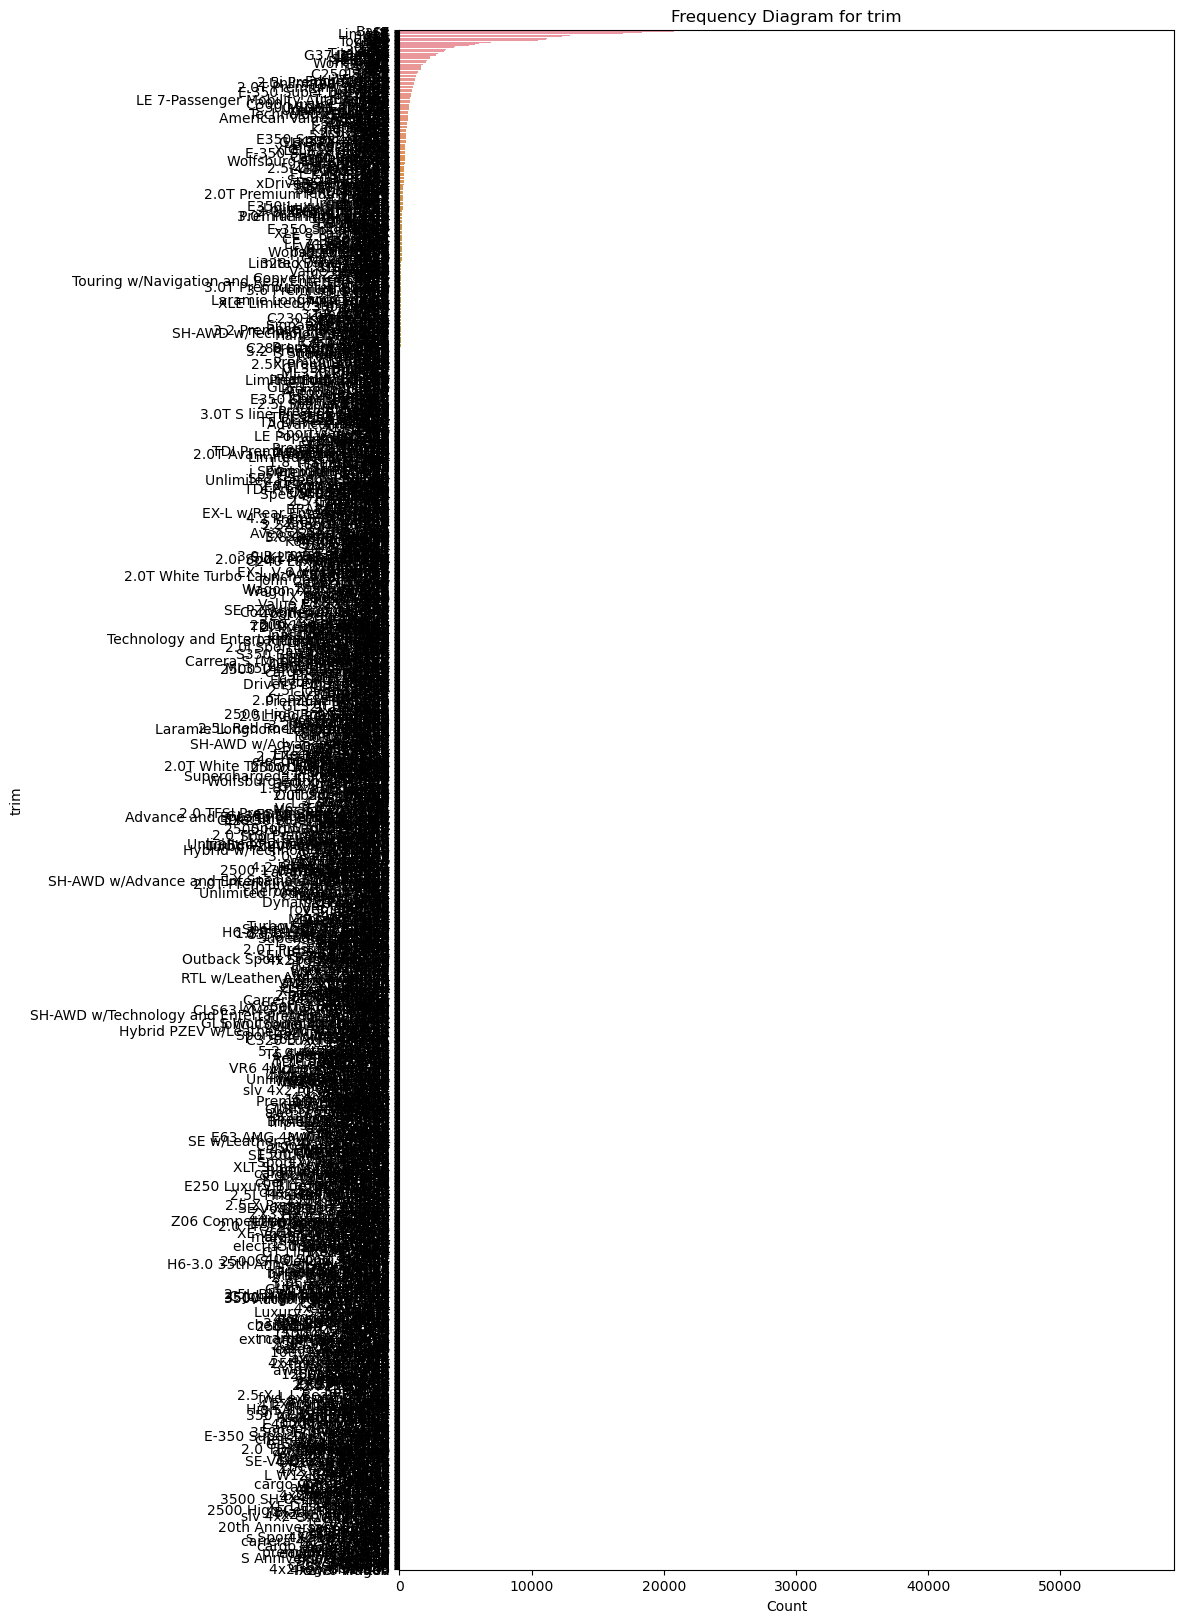

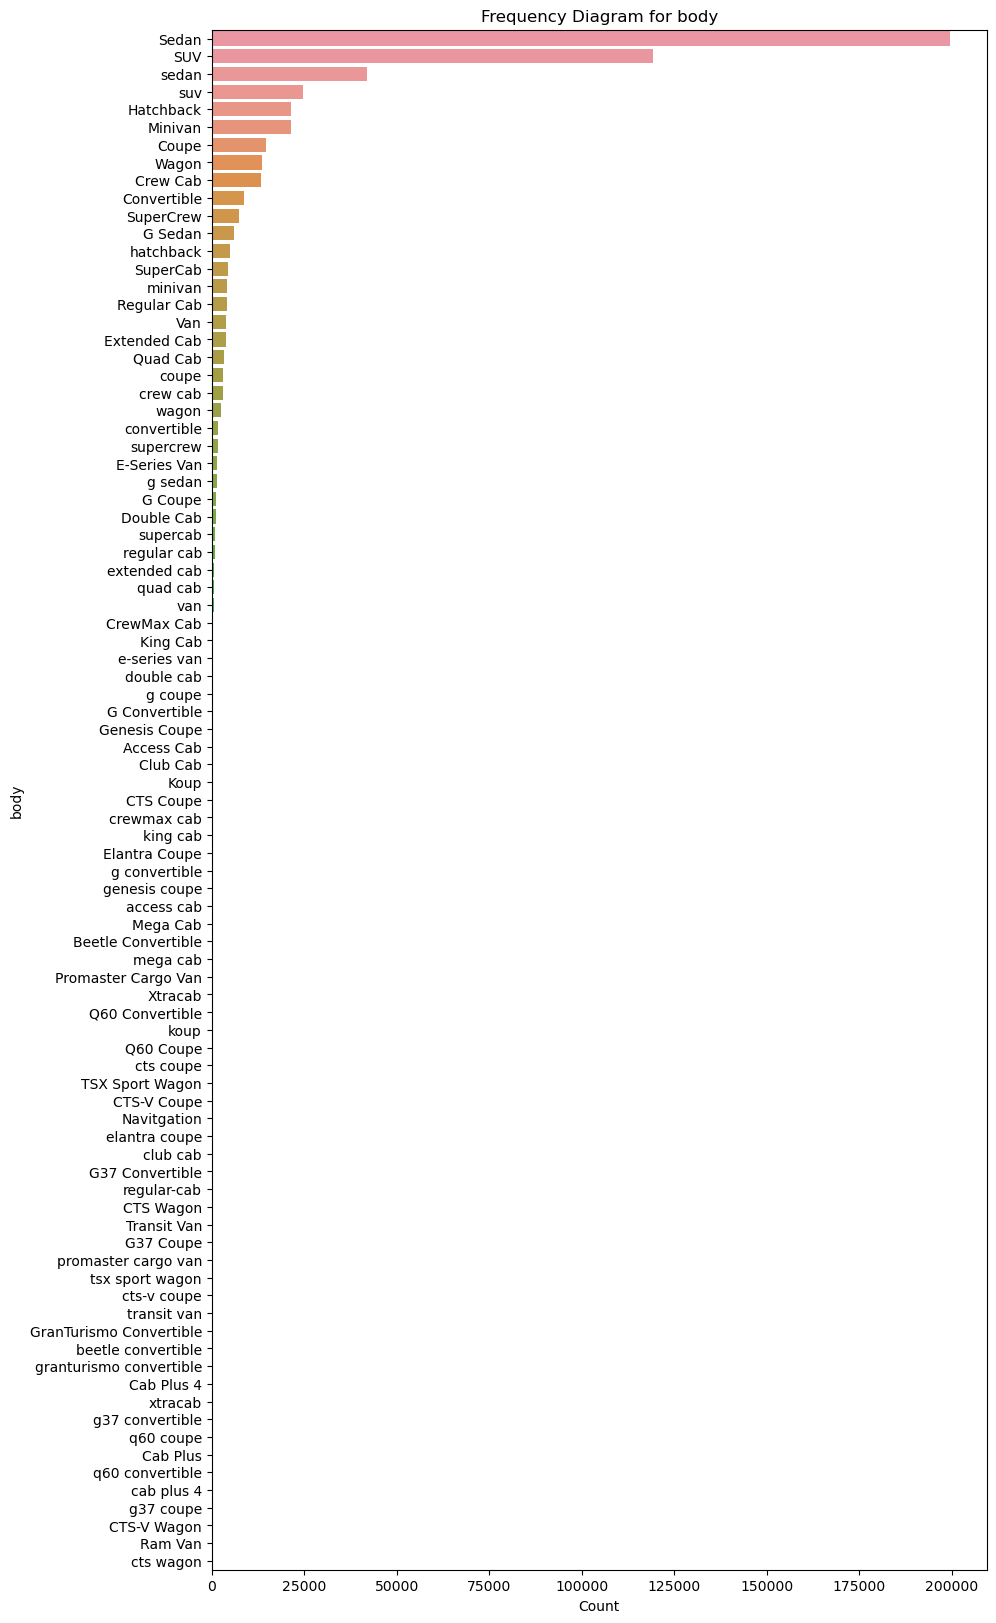

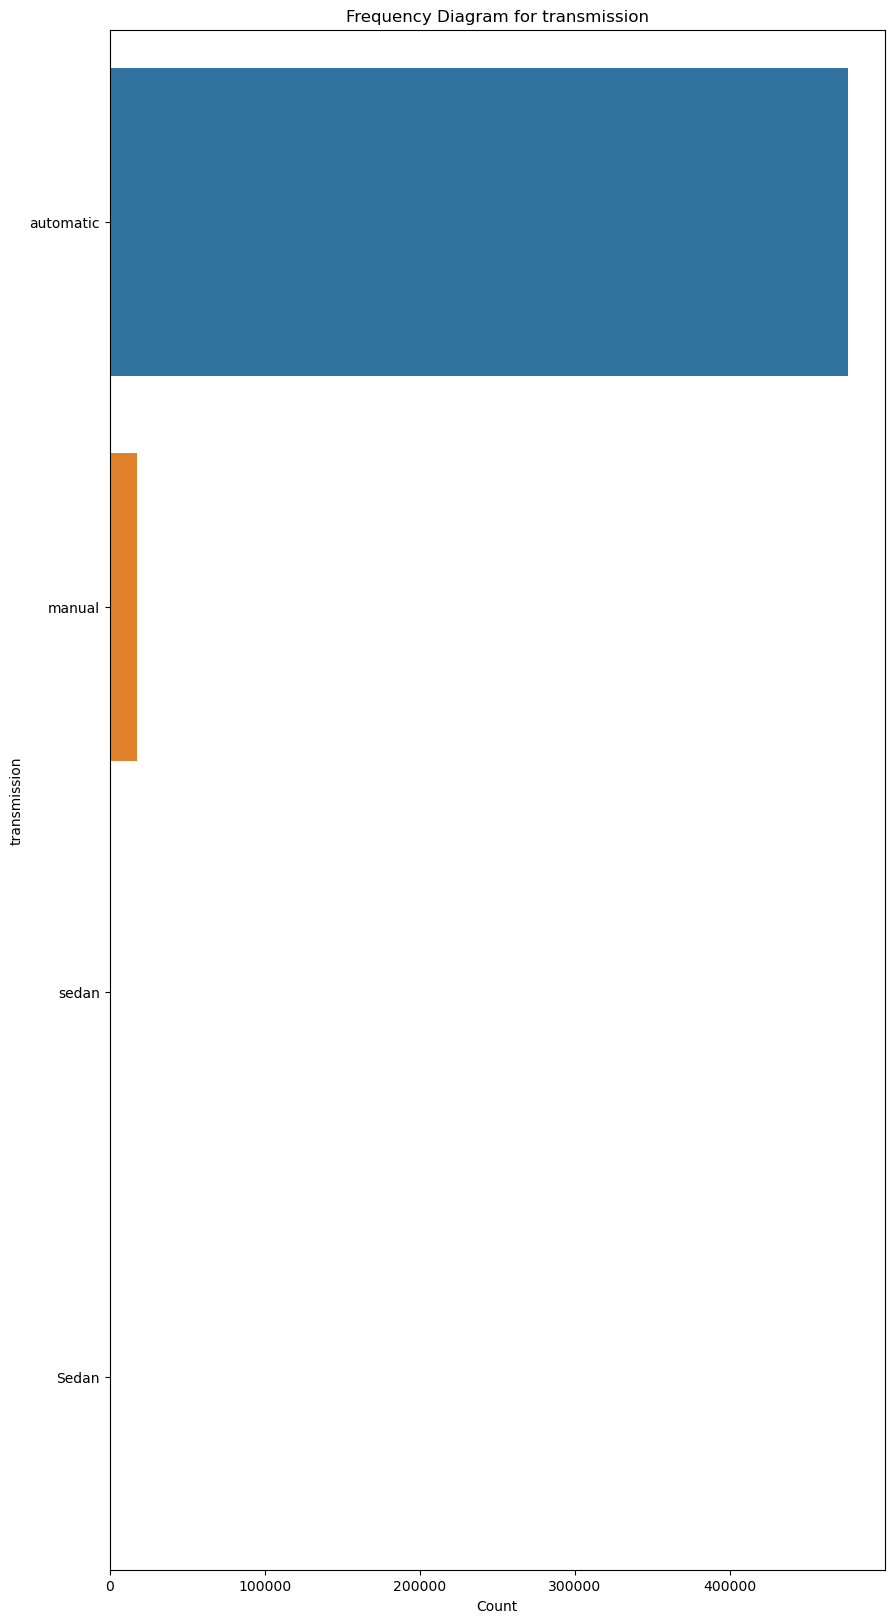

In [ ]:
# Loop through each categorical column
for col in categorical_columns:
    plt.figure(figsize=(10, 20))
    sns.countplot(y=col, data=df, order=df[col].value_counts().index)
    plt.title(f'Frequency Diagram for {col}')
    plt.xlabel('Count')
    plt.ylabel(col)
    plt.show()

In [48]:
# Get number of unique values for each categorical column
unique_counts = {col: df[col].nunique() for col in categorical_columns}
# Convert the dictionary to a DataFrame for better readability (optional)
unique_counts_df = pd.DataFrame.from_dict(unique_counts, orient='index', columns=['Unique Values'])

# Display the results
print(unique_counts)
print(unique_counts_df)

{'make': 96, 'model': 973, 'trim': 1963, 'body': 87, 'transmission': 4, 'vin': 550297, 'state': 64, 'color': 46, 'interior': 17, 'seller': 14263, 'saledate': 3766}
              Unique Values
make                     96
model                   973
trim                   1963
body                     87
transmission              4
vin                  550297
state                    64
color                    46
interior                 17
seller                14263
saledate               3766


In [5]:
#Missing value statistic
cols = [] 
cc = []
rr = []
for i in df.columns:
    c = len(df[i]) - df[i].count()
    if c == 0:
        continue
    r = '%.5f%%' % (c * 100/len(df[i]))
    cc.append(c)
    rr.append(r)
    cols.append(i)
null_df = pd.DataFrame({'feature': cols, 'Number of MissingValue': cc, 'Ration of MissingValue': rr})
null_df

,feature,Number of MissingValue,Ration of MissingValue
0,make,10301,1.84329%
1,model,10399,1.86083%
2,trim,10651,1.90592%
3,body,13195,2.36115%
4,transmission,65352,11.69429%
5,vin,4,0.00072%
6,condition,11820,2.11511%
7,odometer,94,0.01682%
8,color,749,0.13403%
9,interior,749,0.13403%


In [6]:
# Get unique values of a column
unique_values = df['transmission'].unique()

print(unique_values)

['automatic' nan 'manual' 'Sedan' 'sedan']


In [7]:
df['transmission'].mode()

0    automatic
Name: transmission, dtype: object

In [8]:
# Fill null values with the mode (most frequent value)
df['transmission'].fillna(df['transmission'].mode()[0], inplace=True)

In [9]:
df = df.dropna(subset=['vin', 'state','sellingprice','saledate','make', 'model', 'trim','body','condition','odometer','color','interior','mmr'])

In [8]:
# Compute the correlation matrix
correlation_matrix = df.corr()

C:\Users\rmct2\AppData\Local\Temp\ipykernel_34656\3036582683.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df.corr()


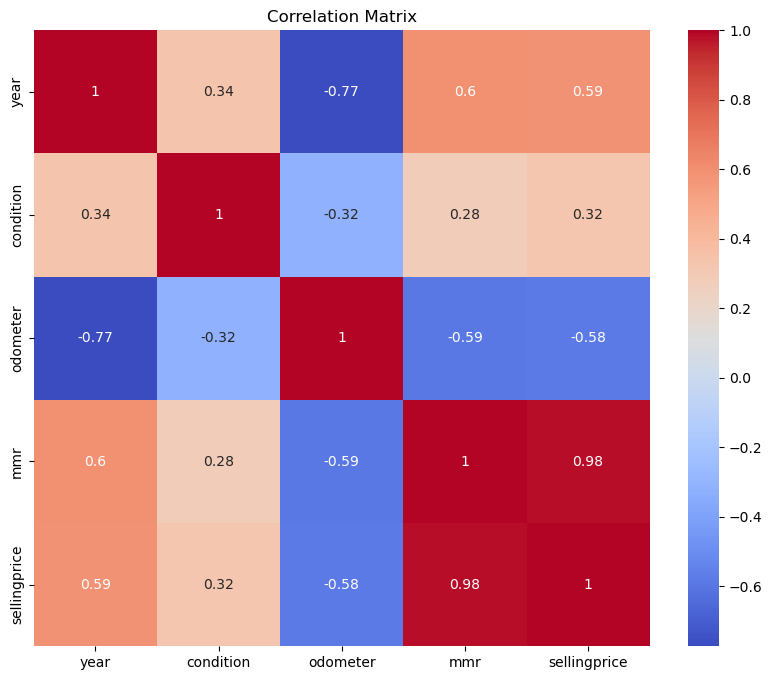

In [9]:
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', square=True)
plt.title('Correlation Matrix')
plt.show()

In [4]:
#list and drop columns that are less related 
cols_to_drop = ['transmission','sellingprice','saledate','vin']
df.drop(cols_to_drop, axis=1, inplace=True)

In [16]:
df.head()

,year,make,model,trim,body,state,condition,odometer,color,interior,seller,mmr
0,2015,Kia,Sorento,LX,SUV,ca,5.0,16639.0,white,black,kia motors america inc,20500.0
1,2015,Kia,Sorento,LX,SUV,ca,5.0,9393.0,white,beige,kia motors america inc,20800.0
2,2014,BMW,3 Series,328i SULEV,Sedan,ca,45.0,1331.0,gray,black,financial services remarketing (lease),31900.0
3,2015,Volvo,S60,T5,Sedan,ca,41.0,14282.0,white,black,volvo na rep/world omni,27500.0
4,2014,BMW,6 Series Gran Coupe,650i,Sedan,ca,43.0,2641.0,gray,black,financial services remarketing (lease),66000.0


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 533648 entries, 0 to 558836
Data columns (total 12 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   year       533648 non-null  int64  
 1   make       533648 non-null  object 
 2   model      533648 non-null  object 
 3   trim       533648 non-null  object 
 4   body       533648 non-null  object 
 5   state      533648 non-null  object 
 6   condition  533648 non-null  float64
 7   odometer   533648 non-null  float64
 8   color      533648 non-null  object 
 9   interior   533648 non-null  object 
 10  seller     533648 non-null  object 
 11  mmr        533648 non-null  float64
dtypes: float64(3), int64(1), object(8)
memory usage: 52.9+ MB


In [19]:
num_duplicates = df.duplicated().sum()
print(f'Number of duplicate rows: {num_duplicates}')

Number of duplicate rows: 1


In [5]:
df.drop_duplicates(inplace=True)

In [6]:
df.shape

(558836, 12)

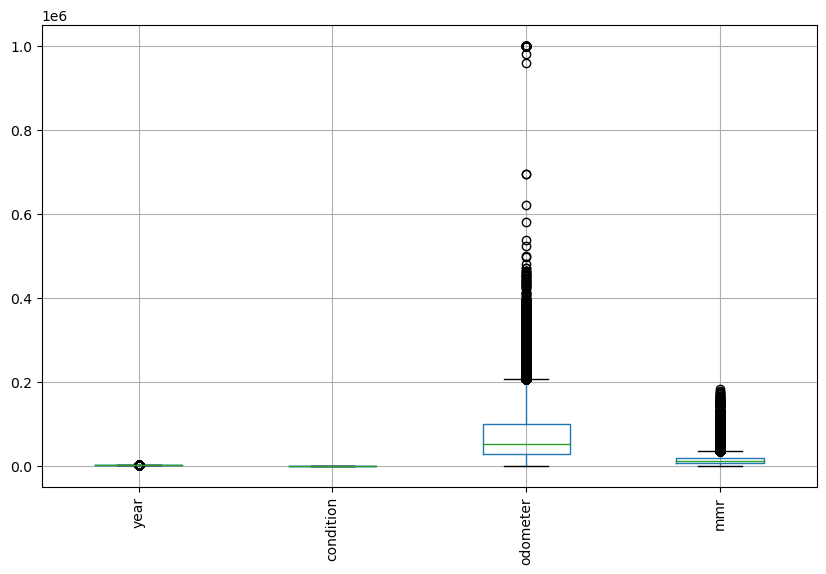

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

# Filter numerical columns
numeric_cols = df.select_dtypes(include='number')

# Plot boxplot
numeric_cols.boxplot(figsize=(10, 6))  # Adjust figsize as needed
plt.xticks(rotation=90)  # Rotate the x-axis labels if necessary
plt.show()

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

def remove_outliers(df, k=1.5):
    for col in df.select_dtypes(include=['float64', 'int64']):  # Apply to numerical columns
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - k * IQR
        upper_bound = Q3 + k * IQR
        # Remove outliers by keeping only values within the bounds
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    
    df = df.reset_index(drop=True)  # Reset index after removing rows
    return df

# Remove outliers
df = remove_outliers(df)

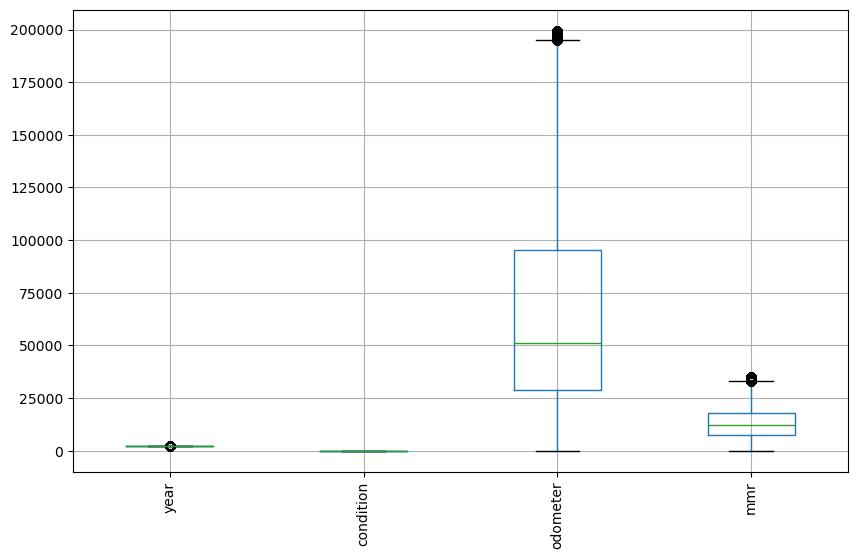

In [9]:
# Generate boxplot for the cleaned data
df.boxplot(figsize=(10, 6))
plt.xticks(rotation=90)  # Rotate column names for readability
plt.show()

In [25]:
df.shape

(495562, 12)

In [10]:
#Split to training and testing

from sklearn.model_selection import train_test_split

x = df.drop(columns = 'mmr')
y = df['mmr']

X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=0.2,random_state=8)

# Step 2 - Build a pipeline of training

In [11]:
from sklearn.pipeline import Pipeline
from category_encoders.target_encoder import TargetEncoder
from xgboost import XGBRegressor

estimators = [
    ('encoder', TargetEncoder()),  # Categorical encoding
    ('reg', XGBRegressor(random_state=8))  # Regression model for continuous target
]
pipe = Pipeline(steps=estimators)
pipe

Pipeline(steps=[('encoder', TargetEncoder()),
                ('reg',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=None, device=None,
                              early_stopping_rounds=None,
                              enable_categorical=False, eval_metric=None,
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=None, n_jobs=None,
                              num_parallel_tree=None, random_state=8, ...))])

# Step 3 - Set up hyperparameter tuning

In [12]:
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

search_space = {
'reg__n_estimators': Integer(100, 500),  # Limited number of trees
    'reg__max_depth': Integer(3, 6),          # Shallower maximum depth
    'reg__learning_rate': Real(0.01, 0.2),    # Limited learning rate range
    'reg__alpha': Real(0, 5),                  # Limited L1 regularization
    'reg__lambda': Real(0, 5) 
}

# Perform Bayesian search over the pipeline with cross-validation
opt = BayesSearchCV(
    pipe, 
    search_space, 
    n_iter=30,  # Fewer iterations for a quicker search
    scoring='neg_mean_squared_error', 
    n_jobs=-1,
    cv=5  # Use cross-validation to evaluate model performance
)

# Step 4 - Train the XGBoost Model

In [ ]:
opt.fit(X_train, Y_train)

C:\Users\rmct2\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [5.0, 0.0, 0.2, 6, 500] before, using random point [2.8371816262935923, 2.0146717543412986, 0.18672039259260093, 5, 470]
  warnings.warn(
C:\Users\rmct2\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0, 0.0, 0.2, 6, 500] before, using random point [1.2381253090289122, 2.6990981480335012, 0.0564597156306322, 6, 438]
  warnings.warn(
C:\Users\rmct2\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [5.0, 0.0, 0.2, 6, 500] before, using random point [1.137926429137551, 3.858790692879719, 0.018956569185100323, 3, 436]
  warnings.warn(
C:\Users\rmct2\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [5.0, 0.0, 0.2, 6, 500] before, using random point [1.359574

In [31]:
# Train the model with the best parameters
best_model = opt.best_estimator_
best_model.fit(X_train, Y_train)

Pipeline(steps=[('encoder',
                 TargetEncoder(cols=['make', 'model', 'trim', 'body', 'state',
                                     'color', 'interior', 'seller'])),
                ('reg',
                 XGBRegressor(alpha=5.0, base_score=None, booster=None,
                              callbacks=None, colsample_bylevel=None,
                              colsample_bynode=None, colsample_bytree=None,
                              device=None, early_stopping_rounds=None,
                              enable_categorical=False, eval_metric=None,
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, lambda=0.0,
                              learning_rate=0.2, max_bin=None,
                              max_cat_threshold=None, max_cat_to_onehot=None,
                              max_delta_step=None, max_depth=6, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=500, n_jobs=None, ...))])

# Step 5 - Evaluate the model and make predictions

In [34]:
# Predictions from your model
predictions_training = best_model.predict(X_train)

# Calculate R-squared
r2 = r2_score(Y_train, predictions_training)
print(f'R-squared for training data: {r2}')

# Calculate Mean Absolute Error
mae = mean_absolute_error(Y_train, predictions_training)
print(f'Mean Absolute Error for training data: {mae}')


R-squared for training data: 0.9811751367330799
Mean Absolute Error for training data: 659.9615513714755


In [35]:
# Make predictions on the test set
predictions_testing = best_model.predict(X_test)

# Calculate R-squared on the test set
r2 = r2_score(Y_test, predictions_testing)
print(f'R-squared on Test Data: {r2}')

# Calculate Mean Absolute Error on the test set
mae = mean_absolute_error(Y_test, predictions_testing)
print(f'Mean Absolute Error on Test Data: {mae}')


R-squared on Test Data: 0.9764073027537844
Mean Absolute Error on Test Data: 714.6304588478656


In [ ]:
# Get the minimum value of 'col1'
min_value = df['mmr'].min()
print(f"Minimum value: {min_value}")

# Get the maximum value of 'col1'
max_value = df['mmr'].max()
print(f"Maximum value: {max_value}")


# Create pickle file

In [39]:
import pickle

# Assuming `xgb_model` is the variable that holds your trained XGBRegressor model
with open('xgb_model.pkl', 'wb') as file:
    pickle.dump(opt, file)

print("Model saved as xgb_model.pkl")

Model saved as xgb_model.pkl
